In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cd  drive/My\ Drive/flowers\ classifier; ls;

cudnn-10.0-linux-x64-v7.5.0.56.tgz  flowerClassifier.ipynb  flower_model.tflite
dataset				    flower_model.h5


In [0]:
!tar -xzvf drive/My\ Drive/flowers\ classifier/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a


In [0]:
!nvidia-smi;

Sat Feb 22 09:26:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
%cd drive/My\ Drive/flowers\ classifier

/content/drive/My Drive/flowers classifier


In [0]:
!pip install tensorflow-gpu==2.0

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import os
import numpy as np                                                                                                                                                                                                                                                                                                                                    
import matplotlib.pyplot as plt

In [0]:
train_dir = "dataset/train"
validate_dir = "dataset/validate"

In [0]:
num_of_train = 0
num_of_validate = 0
for label in os.listdir(train_dir):
    for i in os.listdir(os.path.join(train_dir,label)):
        num_of_train+=1

for label in os.listdir(validate_dir):
    for i in os.listdir(os.path.join(validate_dir,label)):
        num_of_validate+=1

print(num_of_train,num_of_validate)

1492 747


In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=45,
                                           horizontal_flip=True,
                                           zoom_range=0.5)
validation_image_generator = ImageDataGenerator(rescale=1./255,
                                                rotation_range=45,
                                                horizontal_flip=True,
                                                zoom_range=0.5)

In [0]:
!nvidia-smi

Sat Feb 22 09:32:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
epoch=150
batch_size = 32

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(224, 224))

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validate_dir,
                                                              shuffle=True,
                                                              target_size=(224, 224))

Found 1492 images belonging to 15 classes.
Found 747 images belonging to 15 classes.


In [0]:
sample_training_images, labels = next(train_data_gen)
labels[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

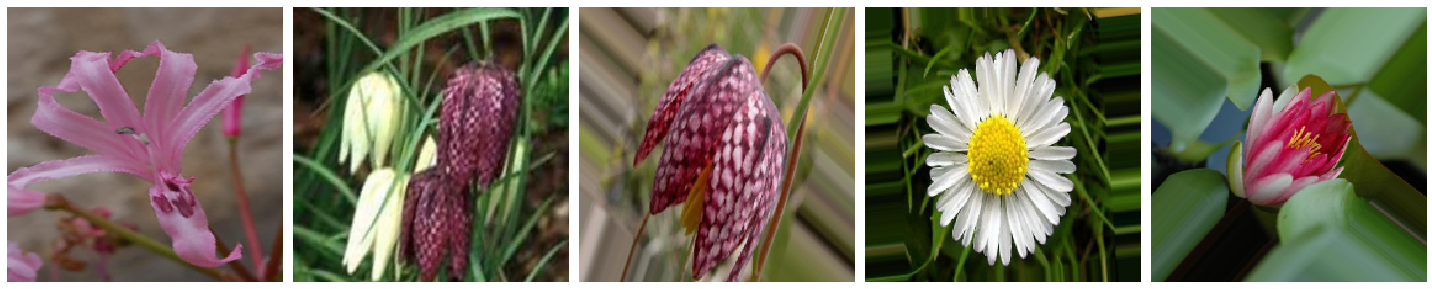

2


In [0]:
def plotImages(images_arr,labels):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    #axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    print(labels)

plotImages(sample_training_images[:5],np.argmax(labels[:5]))

# model


In [0]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=15, activation='softmax'))


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 64)        5

In [0]:
!nvidia-smi

Sat Feb 22 09:34:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    25W /  70W |    293MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [0]:
!nvidia-smi

Sat Feb 22 09:34:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |    293MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#checkpoint = ModelCheckpoint("flower_model.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

hist = model.fit_generator(generator=train_data_gen, steps_per_epoch=(num_of_train//batch_size), validation_data= val_data_gen, validation_steps=(num_of_validate//batch_size) ,epochs=epoch)

Epoch 1/150
19/46 [===========>..................] - ETA: 8:43 - loss: 2.7074 - accuracy: 0.0872

KeyboardInterrupt: ignored

In [0]:
model.save('flower_model.h5')

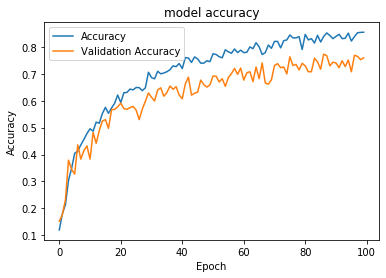

In [0]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
#plt.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

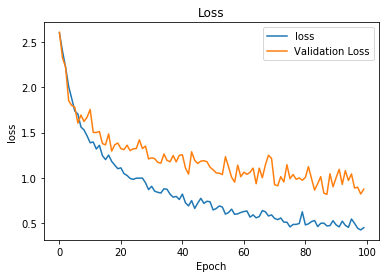

In [0]:
#plt.plot(hist.history["acc"])
#plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [0]:
tfmodel = tf.keras.models.load_model(filepath="flower_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(tfmodel)
#litemodel = converter.convert()
converter.optimizations = [tf.lite.Optimize.DEFAULT]
qlitemodel = converter.convert()
open("flower_model_quant.tflite" , "wb").write(qlitemodel)

4527312

In [0]:
!nvidia-smi

Fri Feb 21 18:35:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    24W /  75W |   2427MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  